In [1]:
import os
import sys
import pprint
import csv
import statistics
import pandas as pd
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import radical.pilot as rp
import radical.utils     as ru
import radical.analytics as ra
import rp_analytics as rp_data
import parsl_analytics as parsl_data
from matplotlib import cm
blues = cm.get_cmap(plt.get_cmap('Blues'))
greens = cm.get_cmap(plt.get_cmap('Greens'))
reds = cm.get_cmap(plt.get_cmap('Reds'))
oranges = cm.get_cmap(plt.get_cmap('Oranges'))
purples = cm.get_cmap(plt.get_cmap('Purples'))
greys = cm.get_cmap(plt.get_cmap('Greys'))

# Font sizes
SIZE = 20
plt.rc('font'  , size      = SIZE  ) # controls default text sizes
plt.rc('axes'  , titlesize = SIZE  ) # fontsize of the axes title
plt.rc('axes'  , labelsize = SIZE  ) # fontsize of the x any y labels
plt.rc('xtick' , labelsize = SIZE  ) # fontsize of the tick labels
plt.rc('ytick' , labelsize = SIZE  ) # fontsize of the tick labels
plt.rc('legend', fontsize  = SIZE-2) # legend fontsize
plt.rc('figure', titlesize = SIZE  ) # size of the figure title

from IPython.core.display import display, HTML
# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-ticks')

# Use LaTeX and its body font for the diagrams' text.
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']
mpl.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
!radical-stack
!which python


  python               : 3.6.10
  pythonpath           : 
  virtualenv           : conda-parsl

  radical.analytics    : 0.90.7
  radical.pilot        : 1.4.1
  radical.saga         : 1.4.0
  radical.utils        : 1.4.0

/home/aymen/anaconda3/envs/conda-parsl/bin/python


In [3]:
#RP                = rp_data.get_session_tstamps()
PARSL_TTC         = parsl_data.get_session_tstamps()
PARSL_interchange = parsl_data.get_interchange_tstamps()
PARSL_woker       = parsl_data.get_workers_tstamps()
PARSL_manager     = parsl_data.get_manager_tstamps()

In [ ]:
rp_std = statistics.stdev(RP['Duration'][:4])
parsl_std = statistics.stdev(PARSL_TTC['Duration'][:4])
print(rp_std, parsl_std)
# create figure and axis objects with subplots()
fig,ax=plt.subplots(figsize=(9,6))
RP_gr = statistics.mean(RP['Duration'][:4])
PARSL_gr = statistics.mean(PARSL_TTC['Duration'][:4])
ax.bar(1,RP_gr,yerr=rp_std, width=0.5)
ax.set_xlabel("Middleware")
ax.set_ylabel("TTC in second")
ax.bar(2,PARSL_gr, yerr=parsl_std, width=0.5)
ax.grid()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[2] = 'RADICAL Pilot'
labels[6] = 'PARSL'
ax.title.set_text("Stress-ng 24 tasks/24 cores (1 node)")
ax.set_xticklabels(labels)
plt.show()
#fig.savefig('../figures/parsl-rp-24.pdf', dpi=300, bbox_inches='tight')

In [ ]:
rp_std = 230 #statistics.stdev(RP['Duration'][4:])
parsl_std = statistics.stdev(PARSL_TTC['Duration'][4:])
print(rp_std, parsl_std)
# create figure and axis objects with subplots()
fig,ax=plt.subplots(figsize=(9,6))
RP_gr = statistics.mean(RP['Duration'][4:])
PARSL_gr = statistics.mean(PARSL_TTC['Duration'][4:])
ax.bar(1,RP_gr,yerr=rp_std, width=0.5)
ax.set_xlabel("Middleware")
ax.set_ylabel("TTC in second")
ax.bar(2,PARSL_gr, yerr=parsl_std, width=0.5)
ax.grid()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[2] = 'RADICAL Pilot'
labels[6] = 'PARSL'
ax.title.set_text("Stress-ng 1728 tasks/1728 cores (72 node)")
ax.set_xticklabels(labels)
plt.show()
fig.savefig('../figures/parsl-rp-72.pdf', dpi=300, bbox_inches='tight')

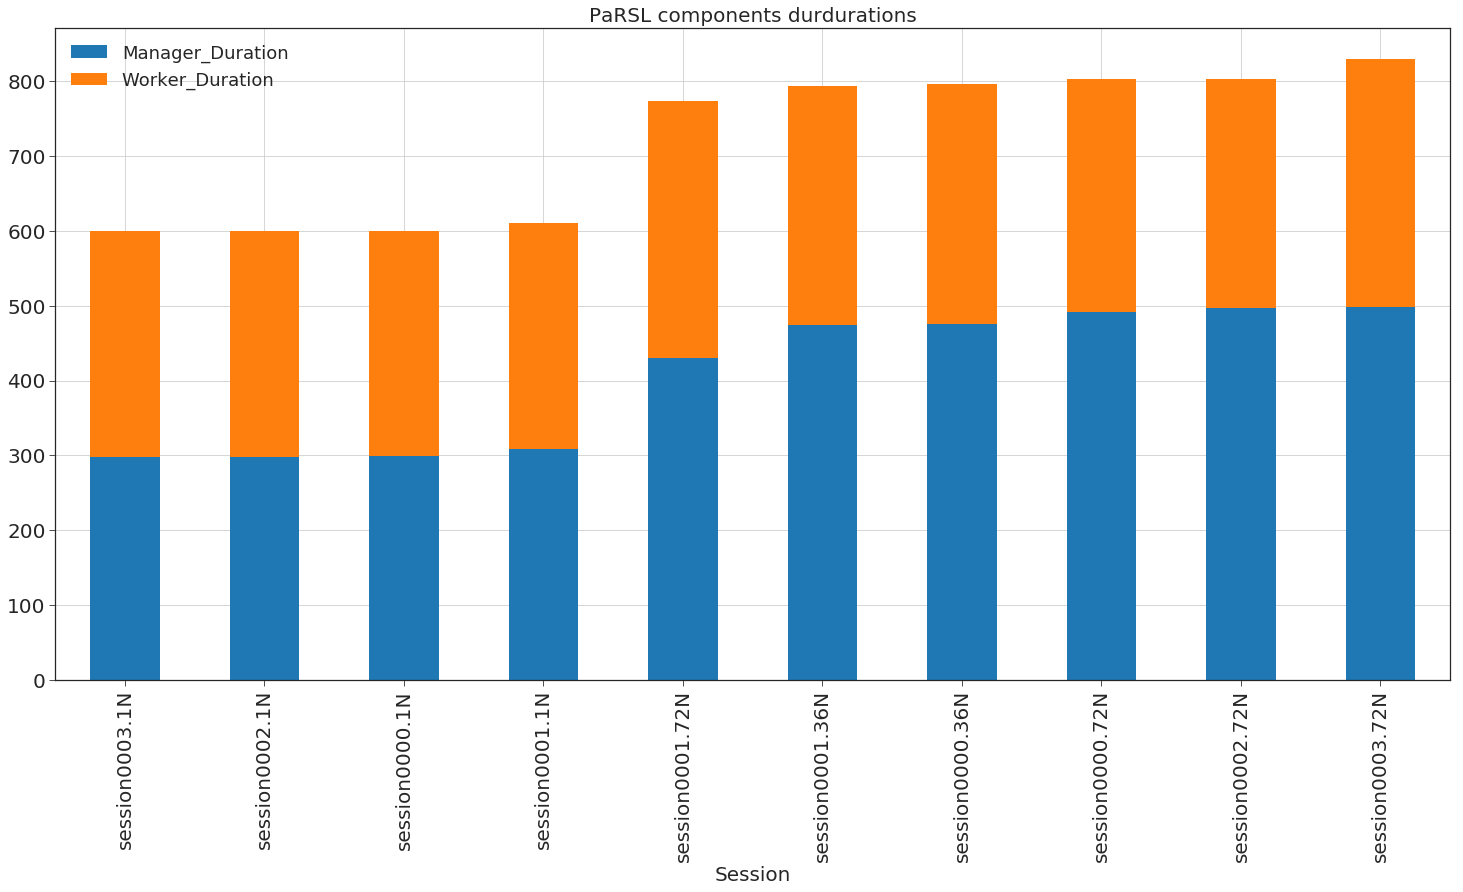

In [4]:
i_dur = PARSL_interchange.groupby('Session').mean().sort_values('Interchange_Duration')
i_std = PARSL_interchange.groupby('Session').std()
m_dur = PARSL_manager.groupby('Session').mean().sort_values('Manager_Duration')
m_std = PARSL_manager.groupby('Session').std()
w_dur = PARSL_woker.groupby('Session').mean().sort_values('Worker_Duration')
w_std = PARSL_woker.groupby('Session').std()
dfs = [w_dur, m_dur,i_dur]
#T1 =  i_dur.merge(m_dur,on='Session').merge(w_dur,on='Session')#include interchange 
T1 =  m_dur.merge(w_dur,on='Session') #do not include interchange 
ax = T1.plot.bar(figsize=(25, 12), grid=True,stacked=True, title="PaRSL components durdurations" )
#forManager_Duration p in ax.patches:
#    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

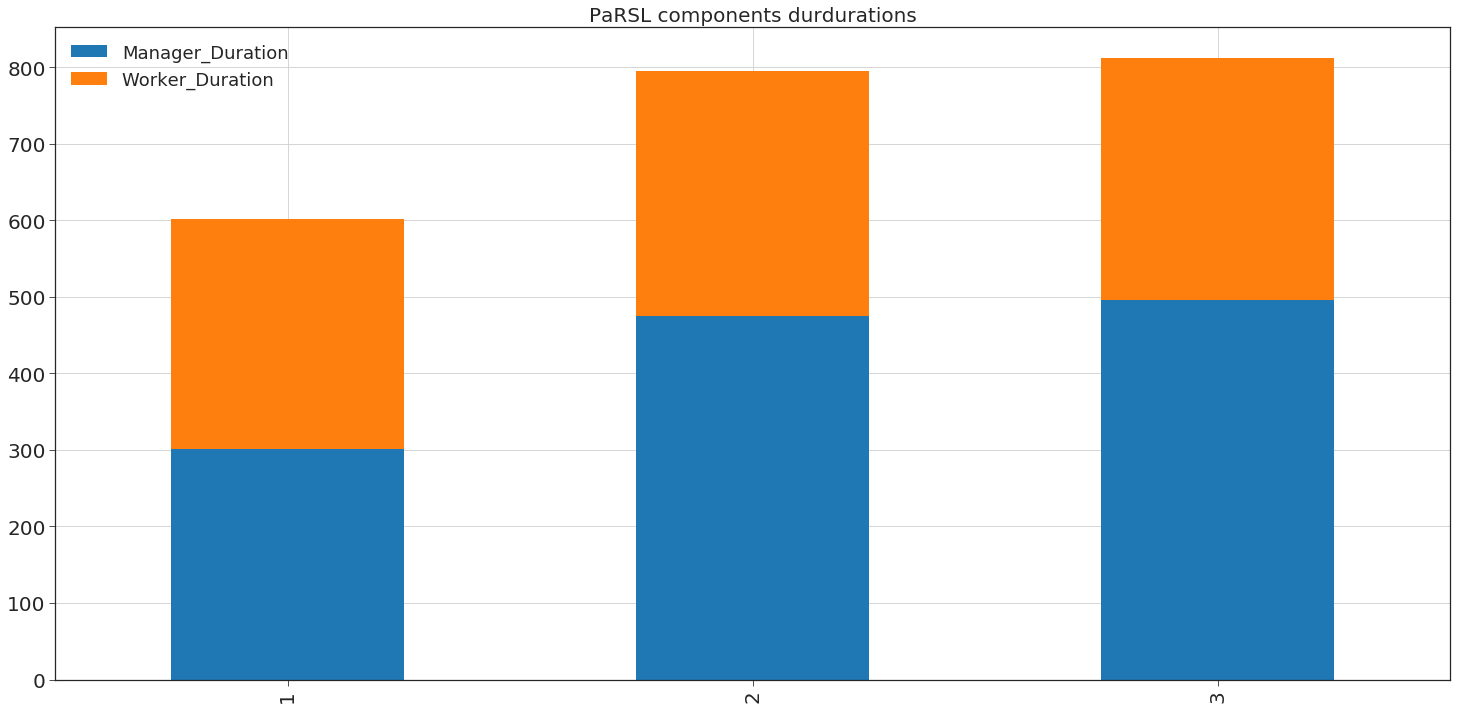

In [5]:
columns = ['Manager_Duration', 'Worker_Duration']

N1  = T1[:4].mean()                         # X4 sessions
N36 = T1[5:7].mean()                        # X2 sessions
N72 = T1[5:10].drop(['session0000.36N','session0001.36N']).mean() # X4 sessions

N1_std  = T1[:4].std()                         # X4 sessions
N36_std = T1[5:7].std()                        # X2 sessions
N72_std = T1[5:10].drop(['session0000.36N','session0001.36N']).std() # X4 sessions

T2_std = pd.DataFrame(columns=columns)
T2_std.loc[1] = [N1_std['Manager_Duration'],N1_std['Worker_Duration']]
T2_std.loc[2] = [N36_std['Manager_Duration'],N36_std['Worker_Duration']]
T2_std.loc[3] = [N72_std['Manager_Duration'],N72_std['Worker_Duration']]


T2 = pd.DataFrame(columns=columns)
T2.loc[1] = [N1['Manager_Duration'],N1['Worker_Duration']]
T2.loc[2] = [N36['Manager_Duration'],N36['Worker_Duration']]
T2.loc[3] = [N72['Manager_Duration'],N72['Worker_Duration']]
ax = T2.plot.bar(figsize=(25, 12), grid=True,stacked=True, title="PaRSL components aggregated durdurations" )

In [6]:
ss = {}
loc = [dI for dI in os.listdir('../RP/sessions/') if os.path.isdir(os.path.join('../RP/sessions/',dI))]
print (len(loc))
for session in range(len(loc)):
    print(loc[session])
    sp = os.path.join('../RP/sessions/',loc[session])
    ss[session] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[session].update({'p': ss[session]['s'].filter(etype='pilot'   , inplace=False),
                        'u': ss[session]['s'].filter(etype='unit'    , inplace=False)})
    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21]
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                  # gray        [24]

# Scale the RGB values to the [0, 1] range, which is the format
# matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (round(r/255.,1), round(g/255.,1), round(b/255.,1))

10
rp.session.js-17-185.jetstream-cloud.org.aymen.018427.0010
session loaded
session loaded
session loaded
rp.session.js-17-185.jetstream-cloud.org.aymen.018427.0011
session loaded
session loaded
session loaded
rp.session.js-17-185.jetstream-cloud.org.aymen.018427.0013
session loaded
session loaded
session loaded
rp.session.js-17-185.jetstream-cloud.org.aymen.018450.0003
session loaded
session loaded
session loaded
rp.session.js-17-185.jetstream-cloud.org.aymen.018485.0001
session loaded
session loaded
session loaded
rp.session.js-17-185.jetstream-cloud.org.aymen.018450.0002
session loaded
session loaded
session loaded
rp.session.js-17-185.jetstream-cloud.org.aymen.018450.0000
session loaded
session loaded
session loaded
rp.session.js-17-185.jetstream-cloud.org.aymen.018485.0000
session loaded
session loaded
session loaded
rp.session.js-17-185.jetstream-cloud.org.aymen.018427.0012
session loaded
session loaded
session loaded
rp.session.js-17-185.jetstream-cloud.org.aymen.018450.0001
se

In [ ]:
from radical.pilot import states as rps

for sid in range(len(loc)):
    u  = ss[sid]['u']

    ss[sid].update({
        'umgr_sched_queue'  : u.duration( event=[{ru.STATE: rps.NEW                        },
                                                 {ru.STATE: rps.UMGR_SCHEDULING            } ]), 
        'umgr_stage_input'  : u.duration( event=[{ru.STATE: rps.UMGR_STAGING_INPUT_PENDING },
                                                 {ru.STATE: rps.UMGR_STAGING_INPUT         } ]), 
        'agent_stage_input' : u.duration( event=[{ru.STATE: rps.AGENT_STAGING_INPUT_PENDING},
                                                 {ru.STATE: rps.AGENT_SCHEDULING_PENDING   } ]), 
        'agent_sched_queue' : u.duration( event=[{ru.STATE: rps.AGENT_SCHEDULING_PENDING   },
                                                 {ru.EVENT: 'schedule_ok'                  } ]), 
        'agent_exec_queue'  : u.duration( event=[{ru.EVENT: 'schedule_ok'                  },
                                                 {ru.STATE: rps.AGENT_EXECUTING            } ]),
        'agent_exec_prep'   : u.duration( event=[{ru.STATE: rps.AGENT_EXECUTING            },
                                                 {ru.EVENT: 'exec_start'                   } ]),
        'agent_exec_rp'     : u.duration( event=[{ru.EVENT: 'exec_start'                   },
                                                 {ru.EVENT: 'cu_start'                     } ]),
        'agent_exec_sh'     : u.duration( event=[{ru.EVENT: 'cu_start'                     },
                                                 {ru.EVENT: 'cu_exec_start'                } ]),
        'agent_exec_cmd'    : u.duration( event=[{ru.EVENT: 'cu_exec_start'                },
                                                 {ru.EVENT: 'cu_exec_stop'                 } ]),
        'agent_term_sh'     : u.duration( event=[{ru.EVENT: 'cu_exec_stop'                 },
                                                 {ru.EVENT: 'cu_stop'                      } ]),
        'agent_term_rp'     : u.duration( event=[{ru.EVENT: 'cu_stop'                      },
                                                 {ru.EVENT: 'exec_stop'                    } ]),
        'agent_unschedule'  : u.duration( event=[{ru.EVENT: 'exec_stop'                    },
                                                 {ru.EVENT: 'unschedule_stop'              } ]),
        'agent_stage_output': u.duration( event=[{ru.EVENT: 'unschedule_stop'              },
                                                 {ru.STATE: rps.UMGR_STAGING_OUTPUT        } ])
    })

In [ ]:
for sid in range(len(loc)):
    print("""
%s:
\tumgr_sched_queue  : %s
\tumgr_stage_input  : %s
\tagent_stage_input : %s
\tagent_sched_queue : %s
\tagent_exec_queue  : %s
\tagent_exec_prep   : %s
\tagent_exec_rp     : %s
\tagent_exec_sh     : %s
\tagent_exec_cmd    : %s
\tagent_term_sh     : %s
\tagent_term_rp     : %s
\tagent_unschedule  : %s
\tagent_stage_output: %s
""" % (sid                         , 
       ss[sid]['umgr_sched_queue'] ,
       ss[sid]['umgr_stage_input'] ,
       ss[sid]['agent_stage_input'],
       ss[sid]['agent_sched_queue'],
       ss[sid]['agent_exec_queue'] , 
       ss[sid]['agent_exec_prep']  , 
       ss[sid]['agent_exec_rp']    , 
       ss[sid]['agent_exec_sh']    , 
       ss[sid]['agent_exec_cmd']   , 
       ss[sid]['agent_term_sh']    , 
       ss[sid]['agent_term_rp']    , 
       ss[sid]['agent_unschedule'] ,
       ss[sid]['agent_stage_output']))

In [7]:
rows = []
for sid in range(len(loc)):
    u  = ss[sid]['u']
    p  = ss[sid]['p']
    ss[sid].update({
      'ttc'  : p.duration(event=[ {ru.EVENT: 'state'         , ru.STATE: rp.NEW                }, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           } ]),
      'ttq_p': p.duration(event=[ {ru.EVENT: 'state'         , ru.STATE: rp.PMGR_ACTIVE_PENDING}, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE        } ]),
      'ttx_u': u.duration( event=[ {ru.EVENT: 'cu_exec_start', ru.STATE: None                  },      
                                   {ru.EVENT: 'cu_exec_stop' , ru.STATE: None                  } ]),
      'ttx_p': p.duration(event=[ {ru.EVENT: 'state'         , ru.STATE: rp.PMGR_ACTIVE        },
                                  [{ru.EVENT: 'state'        , ru.STATE: rp.DONE               },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED             },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           }]])})
    
    ss[sid].update({'ovh_rtc':(ss[sid]['ttx_p'])-ss[sid]['ttx_u']})
    print(ss[sid]['ttx_p'],ss[sid]['ttx_u'], len(ss[sid]['u'].get()))
    rows.append([ss[sid]['ttx_p'], ss[sid]['ttx_u'],int(len(ss[sid]['u'].get())/24)])
T3 = pd.DataFrame(rows, columns=["Pilot_runtime", "TTX","Nodes"])

509.3666760921478 303.0 24
511.5156936645508 304.0 24
509.1485290527344 302.0 24
601.7257556915283 392.0 1728
919.599561214447 405.0 864
573.3278982639313 363.0 1728
594.3901948928833 385.0 1728
1043.386521100998 419.0 864
510.23553800582886 302.0 24
600.7690279483795 391.0 1728


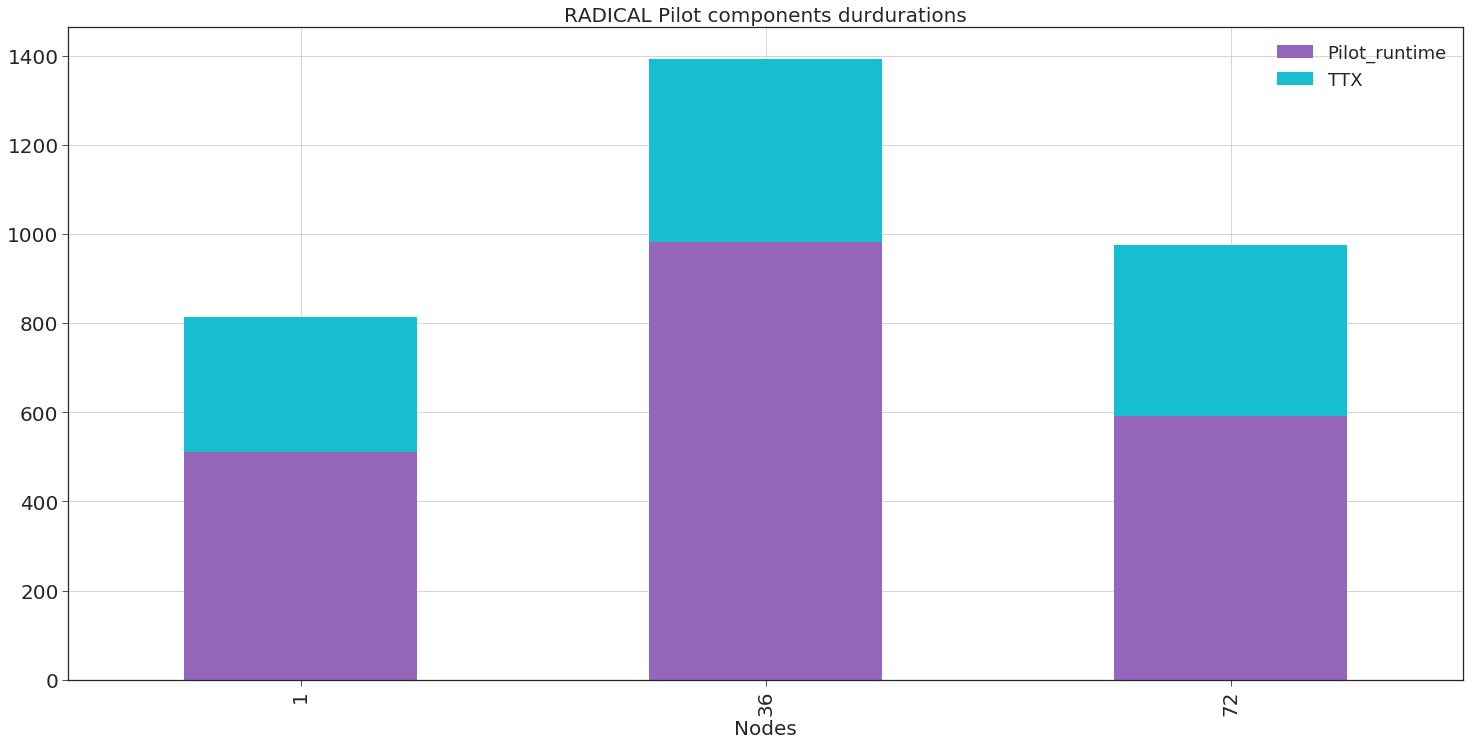

In [8]:
T4   = T3.sort_values('Nodes').reset_index()
T4.drop(['index'],axis=1, inplace=True)
T5   = T4.groupby(['Nodes']). mean()
ax2  = T5.plot.bar(figsize=(25, 12), grid=True,stacked=True,color=['C4', 'C9'], title="RADICAL Pilot components durdurations" )

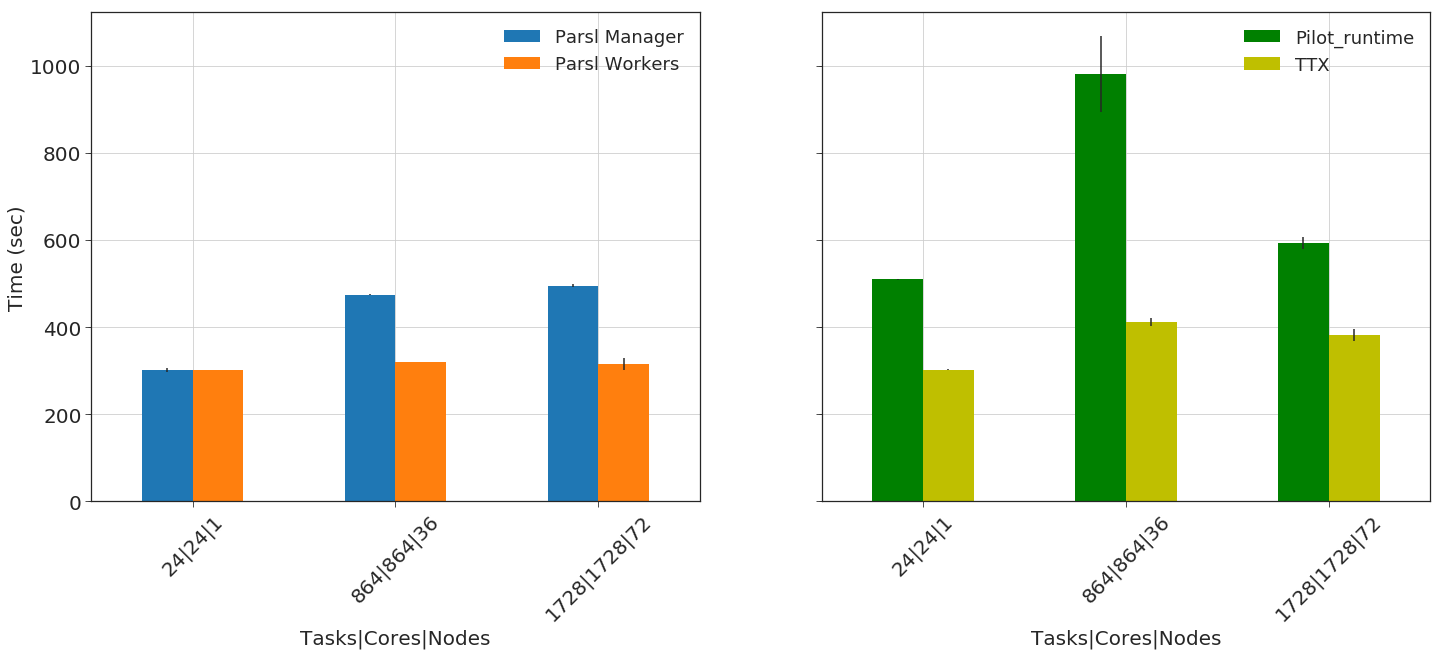

In [9]:
fig, axes = plt.subplots(1,2,sharey=True)
fig.set_size_inches(24,9)

T2.plot.bar(ax = axes[0], yerr = T2_std, grid=True)
T5.plot.bar(ax = axes[1], yerr = T4.groupby(['Nodes']).std(),color=['g','y'], grid=True)

axes[0].set_ylabel("Time (sec)")
axes[0].set_xlabel("Tasks|Cores|Nodes")
axes[1].set_xlabel("Tasks|Cores|Nodes")

labels = [item.get_text() for item in axes[1].get_xticklabels()]
labels[0] = '24|24|1'
labels[1] = '864|864|36'
labels[2] = '1728|1728|72'

axes[0].set_xticklabels(labels,rotation=45)
axes[1].set_xticklabels(labels,rotation=45)
mylabels= ['Parsl Manager','Parsl Workers']
axes[0].legend(labels=mylabels)
fig.savefig('../figures/parsl-rp-all-nodes', dpi=300, bbox_inches='tight')

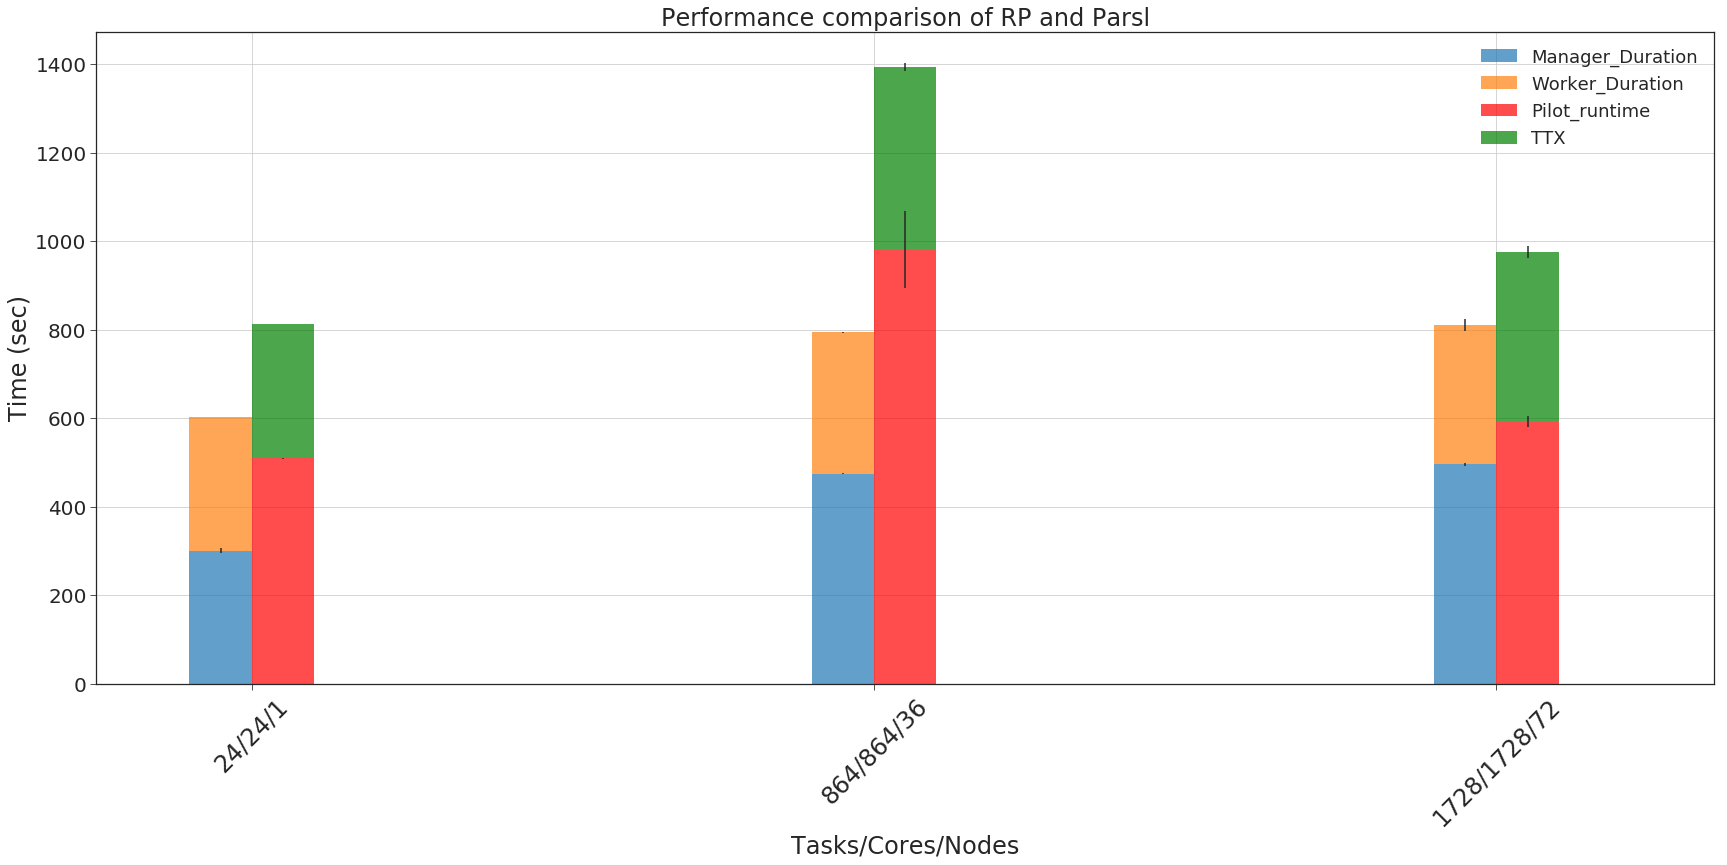

In [11]:
#matplotlib.style.use('ggplot')
fwidth = 29
fhight = 12
mylabels= ['Parsl Manager','Parsl Worker','RP Pilot_runtime', 'Unit TTX']
fig, ax3 = plt.subplots(figsize=(fwidth, fhight))
T2.plot.bar(stacked=True, yerr =T2_std, width=0.1, position=1, ax=ax3, alpha=0.7)
T5.plot.bar(stacked=True, yerr =T4.groupby(['Nodes']).std() ,width=0.1, position=0,color=['r', 'g'], ax=ax3, alpha=0.7)
ax3.set_ylabel("Time (sec)",size=24)
ax3.set_xlabel("Tasks/Cores/Nodes",size=24)
plt.legend(labels=mylabels)
plt.legend(loc="best")

labels = [item.get_text() for item in ax3.get_xticklabels()]
labels[0] = '24/24/1'
labels[1] = '864/864/36'
labels[2] = '1728/1728/72'

ax3.set_xticklabels(labels)
plt.xticks(rotation=45,size =24)
plt.title('Performance comparison of RP and Parsl', size=24)
plt.grid(True)
plt.show()

303.0 (24, 24, 1)
304.0 (24, 24, 1)
302.0 (24, 24, 1)
392.0 (1728, 1728, 72)
405.0 (864, 864, 36)
363.0 (1728, 1728, 72)
385.0 (1728, 1728, 72)
419.0 (864, 864, 36)
302.0 (24, 24, 1)
391.0 (1728, 1728, 72)


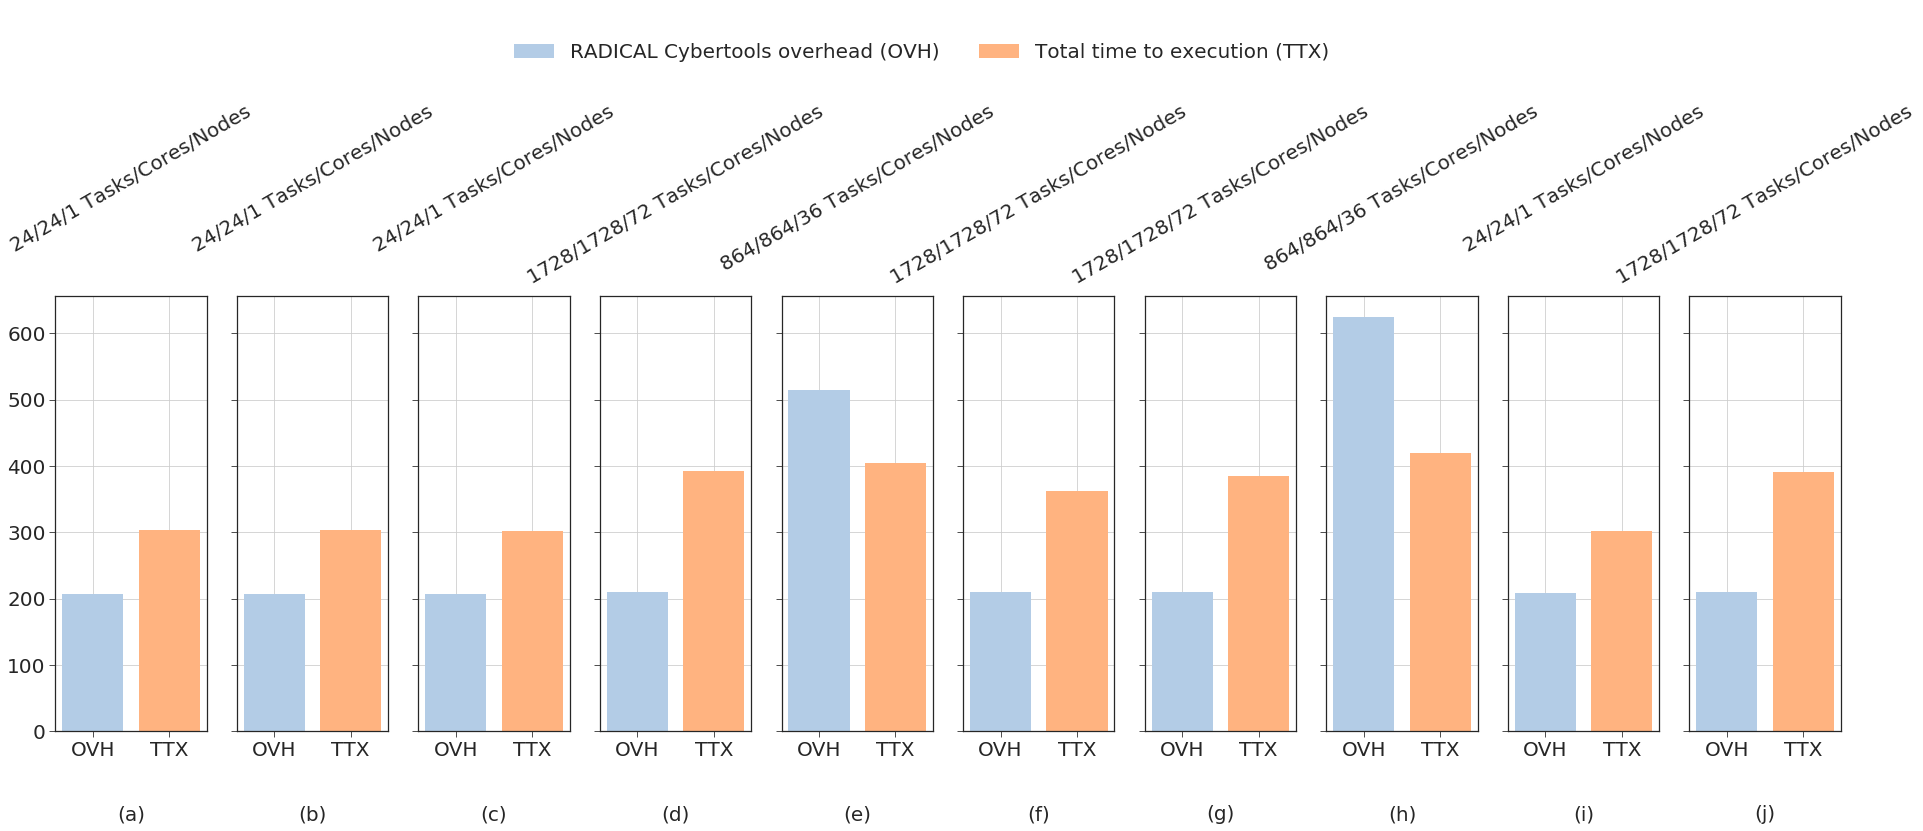

In [12]:
fwidth = 32
fhight = 8
fig, axarr = plt.subplots(1, len(loc), sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in range(len(loc)):
    nunit = len(ss[sid]['u'].get())
    nnodes= nunit/24
    ncore = nunit
    ax = axarr[i]
    ax.set_title('%s/%s/%s Tasks/Cores/Nodes' % (int(nunit),int(ncore), int(nnodes)), rotation = 30,y=1.4)
    #ax.title.set_text('%s/%s/%s Tasks/Cores/Nodes' % (24,24, int(1)))
    print(ss[sid]['ttx_u'], (int(nunit),int(ncore), int(nnodes)))
    ax.bar(x = 'OVH', height = ss[sid]['ovh_rtc'], color = tableau20[1])
    ax.bar(x = 'TTX', height = ss[sid]['ttx_u']  , color = tableau20[3])
    ax.grid()
    ax.set_xlabel('(%s)' % j, labelpad=45)

    i = i+1
    j = chr(ord(j) + 1)


fig.legend(['RADICAL Cybertools overhead (OVH)', 'Total time to execution (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.4, 1.4), fontsize=20, ncol=2)
#plt.savefig('../figures/rp_aggregated_overheads.pdf', dpi=300, bbox_inches='tight')

## Breaking Down the sessions based on their events

In [ ]:
plt.rc('text', usetex=False)

fwidth = 32
fhight = 8
fig, axarr = plt.subplots(1,  len(loc), sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'


for sid in range(len(loc)):
    
    ax = axarr[i]
    nunit = len(ss[sid]['u'].get())
    nnodes= nunit/24
    ncore = nunit
    ax = axarr[i]
    ax.set_title('%s/%s/%s Tasks/Cores/Nodes' % (int(nunit),int(ncore), int(nnodes)), rotation = 30,y=1.4)
    #ax.title.set_text('%s/%s/%s Tasks/Cores/Nodes' % (24,24, int(1)))

    ax.bar(x = 'umgr_sched_queue', height = ss[sid]['umgr_sched_queue'], color = tableau20[1])
    ax.bar(x = 'umgr_stage_input', height = ss[sid]['umgr_stage_input'], color = tableau20[3])
    ax.bar(x = 'agent_stage_input', height = ss[sid]['agent_stage_input'], color = tableau20[5])
    ax.bar(x = 'agent_sched_queue', height = ss[sid]['agent_sched_queue'], color = tableau20[7])
    ax.bar(x = 'agent_exec_queue', height = ss[sid]['agent_exec_queue'], color = tableau20[9])
    ax.bar(x = 'agent_exec_prep', height = ss[sid]['agent_exec_prep'], color = tableau20[11])
    ax.bar(x = 'agent_exec_rp', height = ss[sid]['agent_exec_rp'], color = tableau20[13])
    ax.bar(x = 'agent_exec_sh', height = ss[sid]['agent_exec_sh'], color = tableau20[15])
    ax.bar(x = 'agent_exec_cmd', height = ss[sid]['agent_exec_cmd'], color = tableau20[17])
    ax.bar(x = 'agent_term_sh', height = ss[sid]['agent_term_sh'], color = tableau20[19])
    ax.bar(x = 'agent_term_rp', height = ss[sid]['agent_term_rp'], color = tableau20[21])
    ax.bar(x = 'agent_unschedule', height = ss[sid]['agent_unschedule'], color = tableau20[2])
    ax.bar(x = 'agent_stage_output', height = ss[sid]['agent_stage_output'], color = tableau20[4])
    ax.grid()
    ax.set_xlabel('(%s)' % j, labelpad=45)
    ax.tick_params(axis='x', labelrotation=90)
    
    i = i+1
    j = chr(ord(j) + 1)

fig.text(0.08,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=2)
fig.text(0.5 , -0.8 , 'Metric'  , ha='center', fontsize=24)
fig.savefig('../figures/rp-session-events.pdf', dpi=300, bbox_inches='tight')

## Breaking down the units of a single session based on their time stamps

In [ ]:
event_list   = \
    [
     {ru.STATE: 'NEW'                          , ru.EVENT: 'state'           },
     #{ru.STATE: 'UMGR_SCHEDULING_PENDING'      , ru.EVENT: 'state'           },
     #{ru.STATE: 'UMGR_SCHEDULING'              , ru.EVENT: 'state'           },
     #{ru.STATE: 'UMGR_STAGING_INPUT_PENDING'   , ru.EVENT: 'state'           },
     #{ru.STATE: 'UMGR_STAGING_INPUT'           , ru.EVENT: 'state'           },
     {ru.STATE: 'AGENT_STAGING_INPUT_PENDING'  , ru.EVENT: 'state'           },
     {ru.STATE: None                           , ru.EVENT: 'get'             },
     {ru.STATE: 'AGENT_STAGING_INPUT'          , ru.EVENT: 'state'           },
     #{ru.STATE: 'AGENT_SCHEDULING_PENDING'     , ru.EVENT: 'state'           },
     #{ru.STATE: 'AGENT_SCHEDULING'             , ru.EVENT: 'state'           },
     #{ru.STATE: None                           , ru.EVENT: 'schedule_ok'     },
     #{ru.STATE: 'AGENT_EXECUTING_PENDING'      , ru.EVENT: 'state'           },
     #{ru.STATE: 'AGENT_EXECUTING'              , ru.EVENT: 'state'           },
     {ru.STATE: None                           , ru.EVENT: 'exec_start'      },
     {ru.STATE: None                           , ru.EVENT: 'exec_ok'         },
     {ru.STATE: None                           , ru.EVENT: 'exec_stop'       },
     #{ru.STATE: None                           , ru.EVENT: 'unschedule_start'},
     #{ru.STATE: None                           , ru.EVENT: 'unschedule_stop' },
     #{ru.STATE: 'AGENT_STAGING_OUTPUT_PENDING' , ru.EVENT: 'state'           },
     #{ru.STATE: 'UMGR_STAGING_OUTPUT_PENDING'  , ru.EVENT: 'state'           },
     #{ru.STATE: 'UMGR_STAGING_OUTPUT'          , ru.EVENT: 'state'           },
     #{ru.STATE: 'AGENT_STAGING_OUTPUT'         , ru.EVENT: 'state'           },
     #{ru.STATE: 'DONE'                         , ru.EVENT: 'state'           },
    ]
    
def ppheader(message):
    separator = '\n' + 78 * '-' + '\n'
    print(separator + message + separator)
    
loc = [dI for dI in os.listdir('../RP/sessions/') if os.path.isdir(os.path.join('../RP/sessions/',dI))]

src = os.path.dirname(loc[1])
sid = os.path.basename(loc[1])
session = ra.Session(sid=sid, stype='radical.pilot', src=os.path.join('../RP/sessions/',loc[3]))
print (session)
session.filter(etype='unit', inplace=True)

print('#entities: %d' % len(session.get()))

data = dict()
for thing in session.get():

    tstamps = list()

    for event in event_list:
        times = thing.timestamps(event=event)
        if times: tstamps.append(times[0])
        else    : tstamps.append(np.nan)

    data[thing.uid] = tstamps

# We sort the entities by the timestamp of the first event
# We also derive the durations, first the individual contributions, then the
# overall duration.
# timestamp in the list
sorted_things = sorted(list(data.items()), key=lambda e: e[1][0])
sorted_data   = list()
index         = 0
for uid,tstamps in sorted_things:

    durations = list()
    durations.append(tstamps[-1] - tstamps[0])  # global duration
    for i in range(len(tstamps) - 1):
        durations.append(tstamps[i + 1] - tstamps[i])

    # create plottable data
    sorted_data.append([index] + durations)
    index += 1

# create a numpyarray for plotting
np_data = np.array(sorted_data)
# print np_data

plt.figure(figsize=(20,14))
plt.ylabel('time [s]')
plt.xlabel('#tasks')
for e_idx in range(len(event_list)):
    if e_idx == 0:
        label = 'total'
    else:
        label = '%s - %s' % (ru.event_to_label(event_list[e_idx - 1]),
                             ru.event_to_label(event_list[e_idx]))
    plt.bar(np_data[:,0], np_data[:,(1 + e_idx)], label=label, color = tableau20[e_idx+2])
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4),ncol=3, fancybox=True)
plt.savefig('../figures/rp_unit_dur-72N.pdf', dpi=300, bbox_inches='tight')

## The amount of time the units lived in Mongo-DB waiting to be scheduled 

In [ ]:
UNIT_DURATIONS_DEBUG = {
    'consume' : {
        'u_umngr_create'               : [ {ru.EVENT: 'state'           , ru.STATE: rp.NEW                         },      
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_SCHEDULING_PENDING     }  ],
        'u_umngr_schedule_queue'       : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_SCHEDULING_PENDING     }, 
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_SCHEDULING             }  ],
        'u_umngr_schedule'             : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_SCHEDULING             },               
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_INPUT_PENDING  }  ],
        'u_umngr_stage_in_queue'       : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_INPUT_PENDING  }, 
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_INPUT          }  ], # push to mongodb
        'u_umngr_stage_in'             : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_INPUT          }, 
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_INPUT_PENDING }  ], # wait in mongodb
        'u_agent_stage_in_queue'       : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_INPUT_PENDING },  
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_INPUT         }  ], # pull from mongodb 
        'u_agent_stage_in'             : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_INPUT         },  
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_SCHEDULING_PENDING    }  ], 
        'u_agent_schedule_queue'       : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_SCHEDULING_PENDING    },  
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_SCHEDULING            }  ],
        'u_agent_schedule'             : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_SCHEDULING            },  
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_EXECUTING_PENDING     }  ], 
        'u_agent_execute_queue'        : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_EXECUTING_PENDING     },  
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_EXECUTING             }  ], 
        'u_agent_execute_mkdir_start'  : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_EXECUTING             },  
                                         {ru.EVENT: 'exec_mkdir'      , ru.STATE: None                           }  ], 
        'u_agent_execute_mkdir'        : [ {ru.EVENT: 'exec_mkdir'      , ru.STATE: None                           },
                                         {ru.EVENT: 'exec_mkdir_done' , ru.STATE: None                           }  ],
        'u_agent_execute_layer_start'  : [ {ru.EVENT: 'exec_mkdir_done' , ru.STATE: None                           },
                                         {ru.EVENT: 'exec_start'      , ru.STATE: None                           }  ],
        'u_agent_execute_layer'        : [ {ru.EVENT: 'exec_start'      , ru.STATE: None                           },
                                        [{ru.EVENT: 'exec_ok'         , ru.STATE: None                           },
                                         {ru.EVENT: 'exec_fail'       , ru.STATE: None                           } ]], # orte, ssh, mpi, ... 

        'u_agent_cu_start'             : [ {ru.EVENT: 'cu_start'        , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_cd_done'      , ru.STATE: None                           }  ], # PROBLEM: discontinuity
        'u_agent_cu_pre_execute_start' : [ {ru.EVENT: 'cu_cd_done'      , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_pre_start'    , ru.STATE: None                           }  ],
        'u_agent_cu_pre_execute'       : [ {ru.EVENT: 'cu_pre_start'    , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_pre_stop'     , ru.STATE: None                           }  ],
        'u_agent_cu_execute_start'     : [ {ru.EVENT: 'cu_pre_stop'     , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_exec_start'   , ru.STATE: None                           }  ],
        'u_agent_cu_execute'           : [ {ru.EVENT: 'cu_exec_start'   , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_exec_stop'    , ru.STATE: None                           }  ],
        'u_agent_cu_stop'              : [ {ru.EVENT: 'cu_exec_stop'    , ru.STATE: None                           },
                                         {ru.EVENT: 'cu_stop'         , ru.STATE: None                           }  ],

        'u_agent_cu_unschedule_start'  : [ {ru.EVENT: 'exec_stop'       , ru.STATE: None                           },
                                         {ru.EVENT: 'unschedule_start', ru.STATE: None                           }  ], # PROBLEM: discontinuity
        'u_agent_cu_stage_out_start'   : [ {ru.EVENT: 'unschedule_start', ru.STATE: None                           },
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_OUTPUT_PENDING}  ],
        'u_agent_cu_stage_out_queue'   : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_OUTPUT_PENDING},
                                         {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_OUTPUT        }  ],
        'u_agent_cu_stage_out'         : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_OUTPUT        },
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_OUTPUT_PENDING }  ],
#         'u_agent_cu_unschedule_stop'   : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_OUTPUT_PENDING },
#                                          {ru.EVENT: 'unschedule_stop' , ru.STATE: None                           }  ],
        'u_agent_cu_push_to_umngr'     : [ {ru.EVENT: 'unschedule_stop' , ru.STATE: None                           },
                                         {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_OUTPUT         }  ], # push/pull mongodb
        'u_umngr_cu_destroy'           : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_OUTPUT         },
                                        [{ru.EVENT: 'state'           , ru.STATE: rp.DONE                        },
                                         {ru.EVENT: 'state'           , ru.STATE: rp.CANCELED                    },
                                         {ru.EVENT: 'state'           , ru.STATE: rp.FAILED                      } ]]
    }
}

In [ ]:
u_durations = {}

for sid in range(len(loc)):
    u_durations[sid] = {}

for sid in range(len(loc)):
    for uid in ss[sid]['u'].list('uid'):
        unit = ss[sid]['u'].get(etype='unit', uid=uid)[0]
        durations = {}
        for k,v in UNIT_DURATIONS_DEBUG['consume'].items():
            try:
                
                durations[k] = unit.duration(event=v)
            except:
                pass
        u_durations[sid].update({uid: durations})

In [ ]:
u_durations_df = {}
for sid,durations in u_durations.items():
    u_durations_df[sid] = pd.DataFrame.from_dict(durations, orient='index')

In [ ]:
def fig_setup(figsize=None):
    if not figsize:
        figsize = (13,7)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    return fig, ax



fig, ax  = fig_setup(figsize=(10,14))


labels = []
#muted = ['u_agent_schedule', 'u_agent_cu_execute']

durations = u_durations_df[3]#.drop(muted, axis=1)

for label in durations.columns:
    labels.append(label.replace("_", " ").title().replace("U ", "").replace("Cu", "CU"))
labels = list(reversed(labels))

boxes = []
for duration in list(reversed(durations.columns)):
    boxes.append(durations[duration].values)    

plt.boxplot(boxes, patch_artist=True, labels=labels, vert=False),

ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.set_axisbelow(True)

plt.ylabel('durations')
plt.xlabel('time (s)')